# Machine Learning Model Analysis

The purpose of this analysis is to provide the best machine learning model for Black Rock to predict the likihood if tomorrow's closing price being higher or lower than today's closing price

I am going to use Black rock's maximum of data available to train and test the model

In [3]:
# Importing Libraries
# Data Handling
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)# Financial Data Analysis
import yfinance as yf
import ta
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier # Hiding warnings
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# Loading BlackRock stocks until Aug 29th, 2023
blk = yf.download('BLK', end = '2023-08-29')
blk

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-10-01   14.000000   14.250000   14.000000   14.125000    8.955750   
1999-10-04   14.125000   14.125000   14.000000   14.000000    8.876498   
1999-10-05   14.000000   14.125000   14.000000   14.125000    8.955750   
1999-10-06   14.125000   14.875000   14.125000   14.875000    9.431274   
1999-10-07   14.875000   14.875000   14.062500   14.125000    8.955750   
...                ...         ...         ...         ...         ...   
2023-08-22  671.590027  674.760010  664.609985  665.840027  665.840027   
2023-08-23  668.400024  680.330017  667.119995  678.770020  678.770020   
2023-08-24  678.780029  688.580017  672.969971  673.159973  673.159973   
2023-08-25  676.000000  682.200012  671.260010  675.960022  675.960022   
2023-08-28  681.309998  683.539978  674.630005  679.000000  679.000000   

             Volume  
Date                 
1999-10-01  3162400  
1999-10-04   533400  
1999-10-05   270600  
1999-10-06   205400  
1999-10-07   214200  
...             ...  
2023-08-22   332500  
2023-08-23   386800  
2023-08-24   317900  
2023-08-25   275200  
2023-08-28   430900  

[6015 rows x 6 columns]

In [5]:
open_data = blk['Open']
high_data = blk['High']
low_data = blk['Low']
close_data = blk['Close']
dates = blk.index  

trace = go.Candlestick(x=dates,
                open=open_data,
                high=high_data,
                low=low_data,
                close=close_data)

layout = go.Layout(
    title='BlackRock Stock Price (Candlestick)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price (in USD)'),
    plot_bgcolor='rgba(230, 230, 230, 0.8)',  # Setting a background color for better clarity
)

fig = go.Figure(data=[trace], layout=layout)


fig.show()


In [6]:
# Data Splitting
train = blk[blk.index.year <= 2010] 
test = blk[blk.index.year >= 2011]

In [7]:
# Adding Close_Shift Variable
train['Close_Shift'] = train['Adj Close'].shift(1) 
test['Close_Shift'] = test['Adj Close'].shift(1)

In [8]:
# Adding Daily Returns variable
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100 
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

In [9]:
# Creating target variable on both datasets
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0) 
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [10]:
X_train = train.drop('target', axis = 1)  # Selecting Predictor Variables
y_train = train['target']  # Selecting Target Variable

X_test = test.drop('target', axis = 1)  # Selecting Predictor Variables
y_test = test['target']  # Selecting Target Variable

In [11]:
# Defining feature engineering function
def feature_engineering(df):
# Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5) 
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10) 
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15) 
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20) 
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30) 
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50) 
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80) 
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100) 
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)
    # Adding Price to Simple Moving Averages ratios
    df['sma5_ratio'] = df['Adj Close'] / df['sma5'] 
    df['sma10_ratio'] = df['Adj Close'] / df['sma10'] 
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30'] 
    df['sma50_ratio'] = df['Adj Close'] / df['sma50'] 
    df['sma80_ratio'] = df['Adj Close'] / df['sma80'] 
    df['sma100_ratio'] = df['Adj Close'] / df['sma100'] 
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    # Adding features derived from the indicators above
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int) 
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int) 
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int) 
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close' ].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close' ].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int) 
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int) 
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int) 
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int) 
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int) 
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int) 
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    # Removing NaN values from the dataframe
    df.dropna(inplace = True) 
    return df

In [12]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [13]:
# Removing from y_train and y_test the NaN values that were dropped from X_train and X_t est by the index
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [14]:
# Creating a list of different classification models
classifiers = [
    LogisticRegression(random_state = 42), 
    XGBClassifier(random_state = 42), 
    LGBMClassifier(random_state = 42), 
    CatBoostClassifier(random_state = 42, verbose = False), 
    AdaBoostClassifier(random_state = 42), 
    RandomForestClassifier(random_state = 42)
]
# Iterating over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred) 
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.501
XGBClassifier: AUC Score=0.520
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1331, number of negative: 1301
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 2632, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505699 -> initscore=0.022797
[LightGBM] [Info] Start training from score 0.022797
LGBMClassifier: AUC Score=0.507
CatBoostClassifier: AUC Score=0.502
AdaBoostClassifier: AUC Score=0.515
RandomForestClassifier: AUC Score=0.503


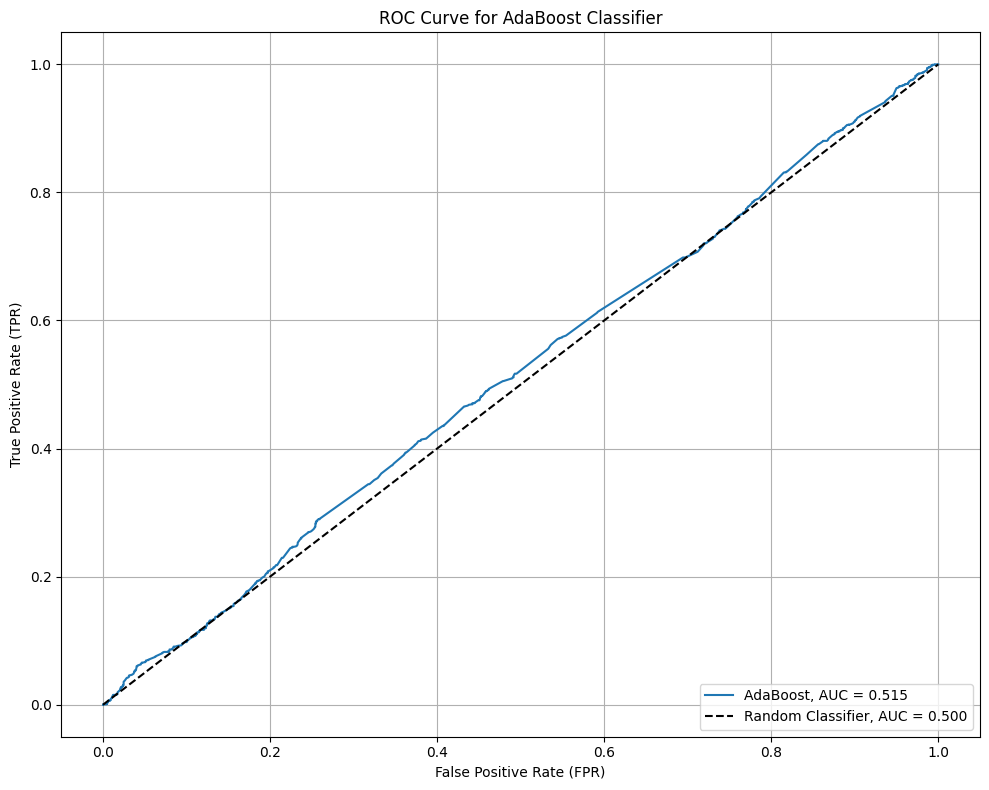

In [15]:
# Train AdaBoostClassifier and get the probabilities for the positive class
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f"AdaBoost, AUC = {auc(fpr, tpr):.3f}")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier, AUC = 0.500")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AUC = 0.5: This suggests no discrimination, which means the model's prediction is no better than random guessing. It's akin to flipping a coin. In your results, LogisticRegression and RandomForestClassifier have AUCs very close to 0.5, suggesting they're not providing any meaningful discrimination for the dataset you've provided.

0.5 < AUC < 1: This indicates some discrimination power, with higher values being better. An AUC of 1 indicates a perfect classifier, where it can perfectly separate the two classes. In practice, an AUC score above 0.8 or 0.9 is considered excellent. In your results, none of the models achieved a high AUC. The highest AUC you have is from AdaBoostClassifier with an AUC of 0.515, which suggests very minimal predictive power beyond random guessing.

AUC < 0.5: Technically, this indicates a model that's doing worse than random guessing. However, you can invert its predictions to achieve an AUC greater than 0.5. In most real-world applications, an AUC less than 0.5 indicates that something may be wrong with the data preprocessing or the way the model is trained.

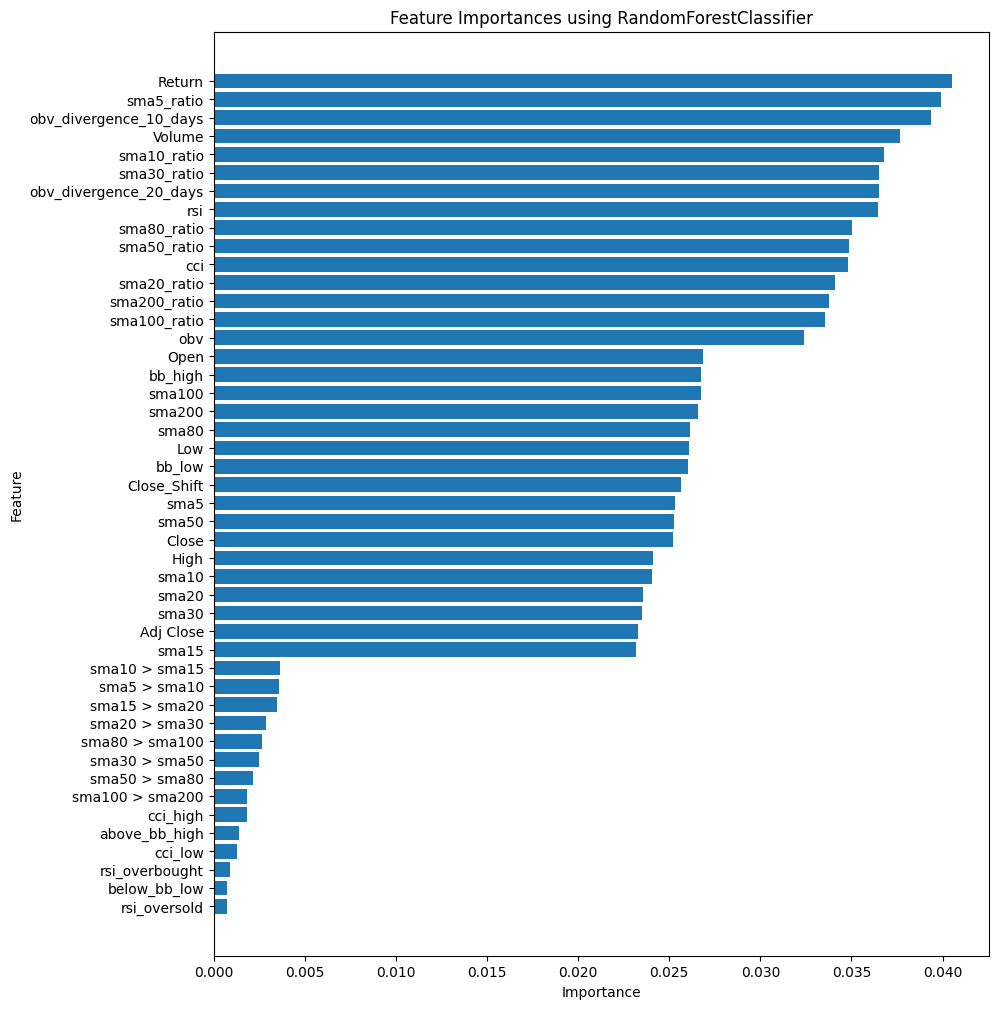

In [16]:
# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Get the indices of the sorted feature importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances using RandomForestClassifier')
plt.show()


In [17]:
y_pred

array([0.48, 0.52, 0.48, ..., 0.3 , 0.32, 0.24])

In [18]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles 
quantile_values = np.quantile(y_pred_proba, quantile_intervals) # Dividing y_pred in 8 different quantiles

classes = pd.cut(y_pred_proba, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range

print(table)

y_true              0    1
row_0                     
(0.187, 0.1911]   188  187
(0.1911, 0.1915]  170  211
(0.1915, 0.1918]  220  207
(0.1918, 0.1919]  146  163
(0.1919, 0.1925]  201  208
(0.1925, 0.1929]  157  181
(0.1929, 0.1972]  160  212
(0.1972, 0.6882]  177  196


In [19]:
sign = np.zeros_like(y_pred_proba) # Creating an array with 0s in the same length as y_pred
# Short selling signal
sign[((y_pred_proba >= 0.3477) & (y_pred_proba < 0.5087)) | ((y_pred_proba > 0.5189) & (y_pred_proba < 0.5195) )] = -1
# Buying signal
sign[((y_pred_proba >= 0.5087) & (y_pred_proba <= 0.5189)) |
((y_pred_proba >= 0.5195) & (y_pred_proba <= 0.5252))] = 1
# Display signal values
sign

array([-1., -1., -1., ...,  0.,  0.,  0.])

In [20]:
X_test.drop('y_true', axis=1, inplace=True, errors='ignore')

adb = AdaBoostClassifier(random_state=42)

adb.fit(X_train, y_train)

X_test['model_returns'] = adb.predict(X_test)

X_test.head(8) # Displaying X_test set

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-10-17  154.250000  155.369995  150.250000  150.729996  110.976677   
2011-10-18  151.020004  157.759995  150.279999  156.300003  115.077682   
2011-10-19  153.000000  154.000000  148.059998  148.919998  109.644028   
2011-10-20  149.039993  153.509995  146.529999  152.160004  112.029541   
2011-10-21  154.509995  155.750000  152.149994  154.320007  113.619850   
2011-10-24  155.699997  158.339996  154.130005  157.479996  115.946411   
2011-10-25  158.229996  158.229996  149.929993  150.380005  110.718956   
2011-10-26  153.229996  155.250000  151.419998  154.369995  113.656708   

             Volume  Close_Shift    Return        sma5       sma10  ...  \
Date                                                                ...   
2011-10-17   619700   114.790520 -3.322437  113.288539  112.039843  ...   
2011-10-18  1155200   110.976677  3.695376  113.765640  112.709843  ...   
2011-10-19  1540800   115.077682 -4.721728  112.723088  112.594246  ...   
2011-10-20  1160300   109.644028  2.175689  112.503690  112.630322  ...   
2011-10-21   941300   112.029541  1.419544  112.269556  113.111835  ...   
2011-10-24   776400   113.619850  2.047671  113.263503  113.276021  ...   
2011-10-25   915900   115.946411 -4.508510  112.391757  113.078699  ...   
2011-10-26   963700   110.718956  2.653341  113.194293  112.958691  ...   

            cci_low  sma5 > sma10  sma10 > sma15  sma15 > sma20  \
Date                                                              
2011-10-17        0             1              1              1   
2011-10-18        0             1              1              1   
2011-10-19        0             1              1              1   
2011-10-20        0             0              1              1   
2011-10-21        0             0              1              1   
2011-10-24        0             0              1              1   
2011-10-25        0             0              1              1   
2011-10-26        0             1              1              1   

            sma20 > sma30  sma30 > sma50  sma50 > sma80  sma80 > sma100  \
Date                                                                      
2011-10-17              0              0              0               0   
2011-10-18              0              0              0               0   
2011-10-19              0              0              0               0   
2011-10-20              0              0              0               0   
2011-10-21              0              0              0               0   
2011-10-24              0              0              0               0   
2011-10-25              0              0              0               0   
2011-10-26              0              0              0               0   

            sma100 > sma200  model_returns  
Date                                        
2011-10-17                0              0  
2011-10-18                0              1  
2011-10-19                0              0  
2011-10-20                0              1  
2011-10-21                0              1  
2011-10-24                0              0  
2011-10-25                0              1  
2011-10-26                0              1  

[8 rows x 47 columns]

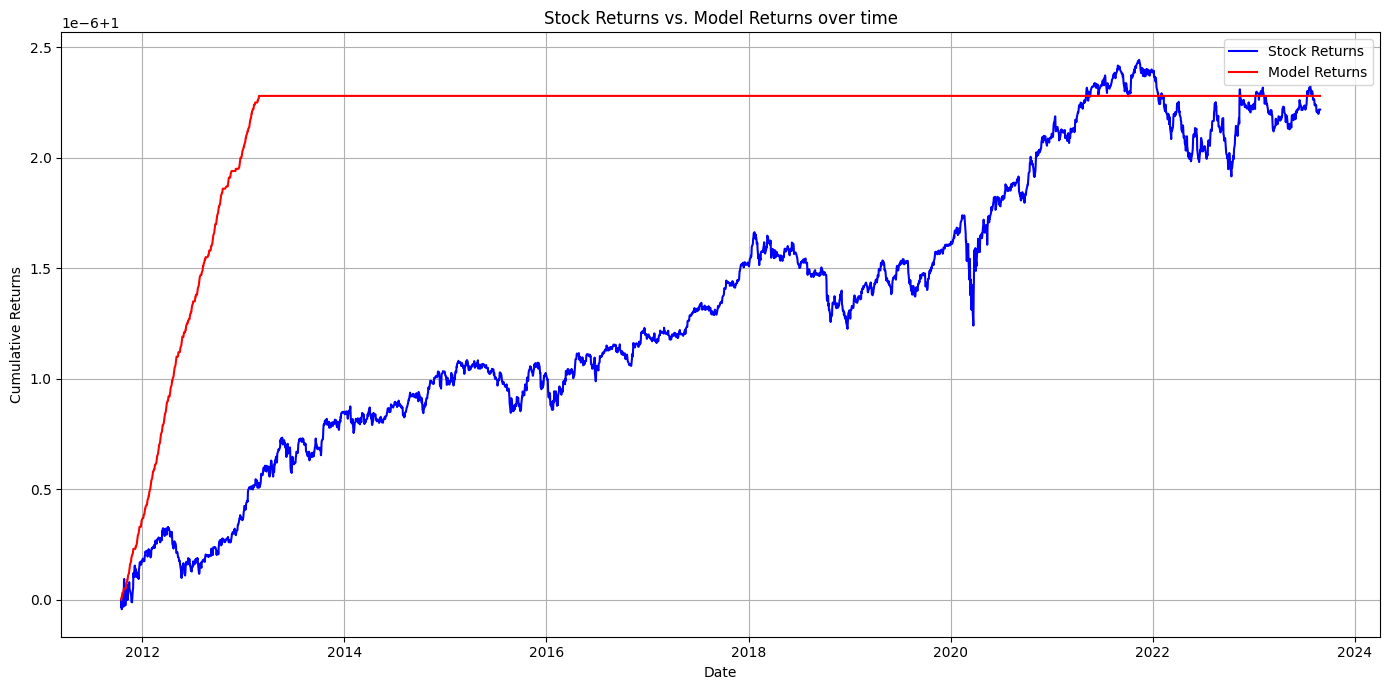

In [21]:

# Assuming you've already created the 'model_returns' column in your X_test dataframe as mentioned in the provided code
# Cumulative returns are a good way to visualize overall performance over time
X_test['cumulative_stock_returns'] = (1 + X_test['Return'] / 100000000).cumprod()
X_test['cumulative_model_returns'] = (1 + X_test['model_returns'] / 100000000).cumprod()

# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(X_test.index, X_test['cumulative_stock_returns'], label='Stock Returns', color='blue')
plt.plot(X_test.index, X_test['cumulative_model_returns'], label='Model Returns', color='red')
plt.title('Stock Returns vs. Model Returns over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [23]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
83/83 [==============================] - 6s 35ms/step - loss: 0.2696
Epoch 2/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2531
Epoch 3/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2569
Epoch 4/100
83/83 [==============================] - 3s 37ms/step - loss: 0.2539
Epoch 5/100
83/83 [==============================] - 3s 37ms/step - loss: 0.2551
Epoch 6/100
83/83 [==============================] - 3s 38ms/step - loss: 0.2558
Epoch 7/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2519
Epoch 8/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2524
Epoch 9/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2530
Epoch 10/100
83/83 [==============================] - 3s 37ms/step - loss: 0.2522
Epoch 11/100
83/83 [==============================] - 3s 37ms/step - loss: 0.2524
Epoch 12/100
83/83 [==============================] - 3s 37ms/step - loss: 0.2521
Epoch 13/100
83/83 [=====

In [24]:
blk

Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-10-01   14.000000   14.250000   14.000000   14.125000    8.955750   
1999-10-04   14.125000   14.125000   14.000000   14.000000    8.876498   
1999-10-05   14.000000   14.125000   14.000000   14.125000    8.955750   
1999-10-06   14.125000   14.875000   14.125000   14.875000    9.431274   
1999-10-07   14.875000   14.875000   14.062500   14.125000    8.955750   
...                ...         ...         ...         ...         ...   
2023-08-22  671.590027  674.760010  664.609985  665.840027  665.840027   
2023-08-23  668.400024  680.330017  667.119995  678.770020  678.770020   
2023-08-24  678.780029  688.580017  672.969971  673.159973  673.159973   
2023-08-25  676.000000  682.200012  671.260010  675.960022  675.960022   
2023-08-28  681.309998  683.539978  674.630005  679.000000  679.000000   

             Volume  
Date                 
1999-10-01  3162400  
1999-10-04   533400  
1999-10-05   270600  
1999-10-06   205400  
1999-10-07   214200  
...             ...  
2023-08-22   332500  
2023-08-23   386800  
2023-08-24   317900  
2023-08-25   275200  
2023-08-28   430900  

[6015 rows x 6 columns]

In [32]:
real_close_price = blk.iloc[:, 3:4].values
real_close_price


array([[ 14.125     ],
       [ 14.        ],
       [ 14.125     ],
       ...,
       [673.15997314],
       [675.96002197],
       [679.        ]])

In [33]:
test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-01-03  191.520004  195.000000  189.529999  190.190002  136.966171   
2011-01-04  191.259995  191.500000  188.710007  190.039993  136.858093   
2011-01-05  190.029999  192.839996  189.250000  192.000000  138.269638   
2011-01-06  192.679993  192.789993  188.360001  189.929993  136.778900   
2011-01-07  191.520004  191.520004  185.460007  188.360001  135.648239   
...                ...         ...         ...         ...         ...   
2023-08-22  671.590027  674.760010  664.609985  665.840027  665.840027   
2023-08-23  668.400024  680.330017  667.119995  678.770020  678.770020   
2023-08-24  678.780029  688.580017  672.969971  673.159973  673.159973   
2023-08-25  676.000000  682.200012  671.260010  675.960022  675.960022   
2023-08-28  681.309998  683.539978  674.630005  679.000000  679.000000   

             Volume  Close_Shift    Return  target  
Date                                                
2011-01-03  1085200          NaN       NaN       0  
2011-01-04   794400   136.966171 -0.078909       1  
2011-01-05   925300   136.858093  1.031393       0  
2011-01-06   727300   138.269638 -1.078138       0  
2011-01-07   886200   136.778900 -0.826634       1  
...             ...          ...       ...     ...  
2023-08-22   332500   671.590027 -0.856177       1  
2023-08-23   386800   665.840027  1.941907       0  
2023-08-24   317900   678.770020 -0.826502       1  
2023-08-25   275200   673.159973  0.415956       1  
2023-08-28   430900   675.960022  0.449727       0  

[3184 rows x 9 columns]

In [34]:
training_set = train.iloc[:, 1:2].values

In [35]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [36]:
dataset_total = pd.concat((train['Close'], train['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(46, 62):  # Adjusted from (60, 76) to (46, 62)
    X_test.append(inputs[i-46:i, 0])  # Adjusted from i-60 to i-46
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_close_price = model.predict(X_test)
predicted_close_price = sc.inverse_transform(predicted_close_price)

1/1 [==============================] - 0s 21ms/step


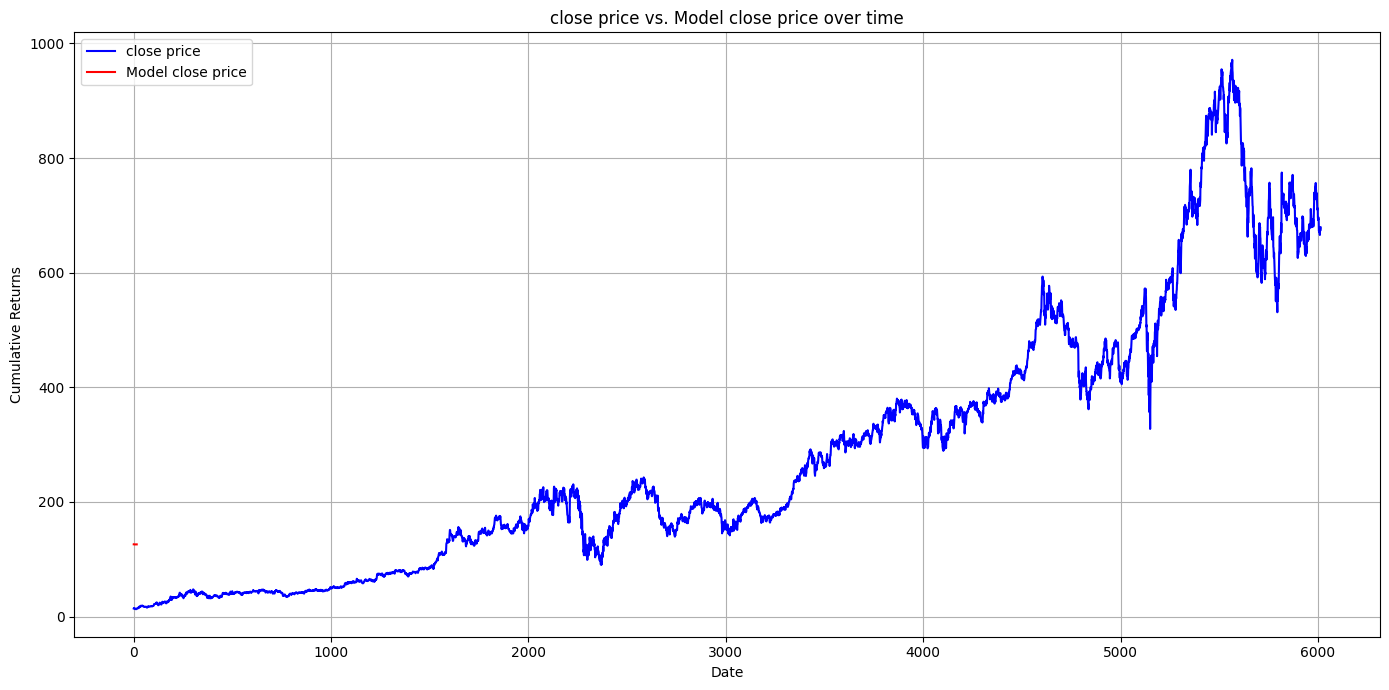

In [37]:
# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(real_close_price, label='close price', color='blue')
plt.plot(predicted_close_price, label='Model close price', color='red')
plt.title('close price vs. Model close price over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion, none of these models are great fit for prediction of the actual stock returns for Black Rock.

In [15]:
# Importing libraries
import pandas as pd
import plotly.express as px 
import ydata_profiling as yp
import yfinance as yf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [16]:
# Obtaining data 
df = yf.Ticker('BLK')
# Selecting historical prices period
blk = df.history(period='30y') # Last 30 years
# See dataframe
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876494    9.035003    8.876494    8.955749   
1999-10-04 00:00:00-04:00    8.955748    8.955748    8.876493    8.876493   
1999-10-05 00:00:00-04:00    8.876494    8.955749    8.876494    8.955749   
1999-10-06 00:00:00-04:00    8.955747    9.431273    8.955747    9.431273   
1999-10-07 00:00:00-04:00    9.431275    9.431275    8.916121    8.955749   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.440002  693.794983  700.539978   

                            Volume  Dividends  Stock Splits  
Date                                                         
1999-10-01 00:00:00-04:00  3162400        0.0           0.0  
1999-10-04 00:00:00-04:00   533400        0.0           0.0  
1999-10-05 00:00:00-04:00   270600        0.0           0.0  
1999-10-06 00:00:00-04:00   205400        0.0           0.0  
1999-10-07 00:00:00-04:00   214200        0.0           0.0  
...                            ...        ...           ...  
2023-08-25 00:00:00-04:00   275200        0.0           0.0  
2023-08-28 00:00:00-04:00   430900        0.0           0.0  
2023-08-29 00:00:00-04:00   502600        0.0           0.0  
2023-08-30 00:00:00-04:00   483900        0.0           0.0  
2023-08-31 00:00:00-04:00   605366        0.0           0.0  

[6018 rows x 7 columns]

In [17]:
# Using Pandas Profiling to generate a report on our dataframe
Profile_1 = yp.ProfileReport(blk)
Profile_1.to_file("Report1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/haochenmiao/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# Removing 'Dividends' and 'Stock Splits' columns
blk = blk.drop(['Dividends','Stock Splits'], axis = 1)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876494    9.035003    8.876494    8.955749   
1999-10-04 00:00:00-04:00    8.955748    8.955748    8.876493    8.876493   
1999-10-05 00:00:00-04:00    8.876494    8.955749    8.876494    8.955749   
1999-10-06 00:00:00-04:00    8.955747    9.431273    8.955747    9.431273   
1999-10-07 00:00:00-04:00    9.431275    9.431275    8.916121    8.955749   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.440002  693.794983  700.539978   

                            Volume  
Date                                
1999-10-01 00:00:00-04:00  3162400  
1999-10-04 00:00:00-04:00   533400  
1999-10-05 00:00:00-04:00   270600  
1999-10-06 00:00:00-04:00   205400  
1999-10-07 00:00:00-04:00   214200  
...                            ...  
2023-08-25 00:00:00-04:00   275200  
2023-08-28 00:00:00-04:00   430900  
2023-08-29 00:00:00-04:00   502600  
2023-08-30 00:00:00-04:00   483900  
2023-08-31 00:00:00-04:00   605366  

[6018 rows x 5 columns]

In [19]:
# Adding two simple moving averages in order to increase the number of features to be analyzed by PyCaret Regression models
blk['SMA7'] = blk.Close.rolling(window=7).mean().round(2)
blk['SMA30'] = blk.Close.rolling(window=30).mean().round(2)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876494    9.035003    8.876494    8.955749   
1999-10-04 00:00:00-04:00    8.955748    8.955748    8.876493    8.876493   
1999-10-05 00:00:00-04:00    8.876494    8.955749    8.876494    8.955749   
1999-10-06 00:00:00-04:00    8.955747    9.431273    8.955747    9.431273   
1999-10-07 00:00:00-04:00    9.431275    9.431275    8.916121    8.955749   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.440002  693.794983  700.539978   

                            Volume    SMA7   SMA30  
Date                                                
1999-10-01 00:00:00-04:00  3162400     NaN     NaN  
1999-10-04 00:00:00-04:00   533400     NaN     NaN  
1999-10-05 00:00:00-04:00   270600     NaN     NaN  
1999-10-06 00:00:00-04:00   205400     NaN     NaN  
1999-10-07 00:00:00-04:00   214200     NaN     NaN  
...                            ...     ...     ...  
2023-08-25 00:00:00-04:00   275200  672.80  709.34  
2023-08-28 00:00:00-04:00   430900  673.51  707.71  
2023-08-29 00:00:00-04:00   502600  676.48  706.11  
2023-08-30 00:00:00-04:00   483900  679.94  704.40  
2023-08-31 00:00:00-04:00   605366  684.90  702.72  

[6018 rows x 7 columns]

In [20]:
# Generating new report with pandas_profiling
Profile_2 = yp.ProfileReport(blk)
Profile_2.to_file("Report2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/haochenmiao/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# Using plotly to plot a candlestick chart of the last 30 years
fig = go.Figure(data=[go.Candlestick(x = blk.index,
                                    open = blk.Open,
                                    high = blk.High,
                                    low = blk.Low,
                                    close = blk.Close),
                     go.Scatter(x=blk.index, y = blk.SMA7, line=dict(color='orange',width=1),name='SMA7'),
                     go.Scatter(x=blk.index, y = blk.SMA30, line=dict(color='green',width=1.5),name='SMA30')])
fig.update_layout(title = 'BlackRock stocks from Oct 10th, 1999 to Aug 30th, 2023')
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()

In [25]:
# Creating a new dataframe containing the last 10 years data to later test how well our predicting model will compare to the closing prices
blk_predict = blk.tail(3000)
# See results
blk_predict

Open        High         Low       Close  \
Date                                                                        
2011-09-29 00:00:00-04:00  112.449240  112.486055  109.018269  111.661446   
2011-09-30 00:00:00-04:00  109.968002  111.595145  108.679545  108.974045   
2011-10-03 00:00:00-04:00  108.090528  109.482062  104.129439  104.379776   
2011-10-04 00:00:00-04:00  103.120808  108.650141  100.867849  108.377716   
2011-10-05 00:00:00-04:00  108.613283  111.278546  107.133390  110.799980   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.440002  693.794983  700.539978   

                            Volume    SMA7   SMA30  
Date                                                
2011-09-29 00:00:00-04:00  1147400  109.67  114.19  
2011-09-30 00:00:00-04:00  1095600  109.75  114.12  
2011-10-03 00:00:00-04:00  1041900  109.44  113.92  
2011-10-04 00:00:00-04:00  1300000  109.39  113.82  
2011-10-05 00:00:00-04:00   869300  109.41  113.64  
...                            ...     ...     ...  
2023-08-25 00:00:00-04:00   275200  672.80  709.34  
2023-08-28 00:00:00-04:00   430900  673.51  707.71  
2023-08-29 00:00:00-04:00   502600  676.48  706.11  
2023-08-30 00:00:00-04:00   483900  679.94  704.40  
2023-08-31 00:00:00-04:00   605366  684.90  702.72  

[3000 rows x 7 columns]

In [26]:
# Removing last 2 years from the original dataframe
blk.drop(blk_predict.index,inplace = True)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876494    9.035003    8.876494    8.955749   
1999-10-04 00:00:00-04:00    8.955748    8.955748    8.876493    8.876493   
1999-10-05 00:00:00-04:00    8.876494    8.955749    8.876494    8.955749   
1999-10-06 00:00:00-04:00    8.955747    9.431273    8.955747    9.431273   
1999-10-07 00:00:00-04:00    9.431275    9.431275    8.916121    8.955749   
...                               ...         ...         ...         ...   
2011-09-22 00:00:00-04:00  105.035046  107.089210  103.238567  106.573830   
2011-09-23 00:00:00-04:00  105.697693  108.878348  105.130769  108.694283   
2011-09-26 00:00:00-04:00  108.974054  110.910426  106.522302  110.696915   
2011-09-27 00:00:00-04:00  113.310611  116.145222  111.278534  112.272491   
2011-09-28 00:00:00-04:00  116.123167  116.123167  109.158129  109.371651   

                            Volume    SMA7   SMA30  
Date                                                
1999-10-01 00:00:00-04:00  3162400     NaN     NaN  
1999-10-04 00:00:00-04:00   533400     NaN     NaN  
1999-10-05 00:00:00-04:00   270600     NaN     NaN  
1999-10-06 00:00:00-04:00   205400     NaN     NaN  
1999-10-07 00:00:00-04:00   214200     NaN     NaN  
...                            ...     ...     ...  
2011-09-22 00:00:00-04:00  1301400  113.19  115.50  
2011-09-23 00:00:00-04:00   770800  112.70  115.18  
2011-09-26 00:00:00-04:00   872500  111.77  114.95  
2011-09-27 00:00:00-04:00  1188000  110.89  114.67  
2011-09-28 00:00:00-04:00   952700  110.08  114.40  

[3018 rows x 7 columns]

In [27]:
# Removing NaN
blk.dropna(inplace=True)
# See Results
blk

Open        High         Low       Close  \
Date                                                                        
1999-11-11 00:00:00-05:00   10.184193   10.303074   10.184193   10.223820   
1999-11-12 00:00:00-05:00   10.303078   11.729658   10.303078   11.412641   
1999-11-15 00:00:00-05:00   11.531524   11.531524   11.095624   11.214506   
1999-11-16 00:00:00-05:00   11.214505   11.214505   11.016369   11.055996   
1999-11-17 00:00:00-05:00   11.214502   11.571147   10.937111   11.095620   
...                               ...         ...         ...         ...   
2011-09-22 00:00:00-04:00  105.035046  107.089210  103.238567  106.573830   
2011-09-23 00:00:00-04:00  105.697693  108.878348  105.130769  108.694283   
2011-09-26 00:00:00-04:00  108.974054  110.910426  106.522302  110.696915   
2011-09-27 00:00:00-04:00  113.310611  116.145222  111.278534  112.272491   
2011-09-28 00:00:00-04:00  116.123167  116.123167  109.158129  109.371651   

                            Volume    SMA7   SMA30  
Date                                                
1999-11-11 00:00:00-05:00    20000   10.00    9.12  
1999-11-12 00:00:00-05:00   248500   10.29    9.20  
1999-11-15 00:00:00-05:00    99200   10.54    9.28  
1999-11-16 00:00:00-05:00    95300   10.69    9.35  
1999-11-17 00:00:00-05:00   107900   10.77    9.41  
...                            ...     ...     ...  
2011-09-22 00:00:00-04:00  1301400  113.19  115.50  
2011-09-23 00:00:00-04:00   770800  112.70  115.18  
2011-09-26 00:00:00-04:00   872500  111.77  114.95  
2011-09-27 00:00:00-04:00  1188000  110.89  114.67  
2011-09-28 00:00:00-04:00   952700  110.08  114.40  

[2989 rows x 7 columns]

In [28]:
# Importing regression lib from PyCaret
from pycaret.regression import *
setup(data = blk, target = 'Close',session_id=123)

In [29]:
ridge = create_model('ridge',fold = 10)

In [30]:
br = create_model('br',fold=10)

In [31]:
lar = create_model('lar',fold=10)

## Tuning Models

In [32]:
# Tuning ridge
ridge_params = {'alpha' : [0.02,0.024,0.025,0.025,0.026,0.03]}
tune_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE',custom_grid = ridge_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [33]:
# Tuning Bayesian Ridge
tune_br = tune_model(br,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


In [34]:
# Tuning Least Angle Regression 
tune_lar = tune_model(lar,n_iter=1000, optimize='RMSE')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 22 candidates, totalling 220 fits


## Visualizing Data

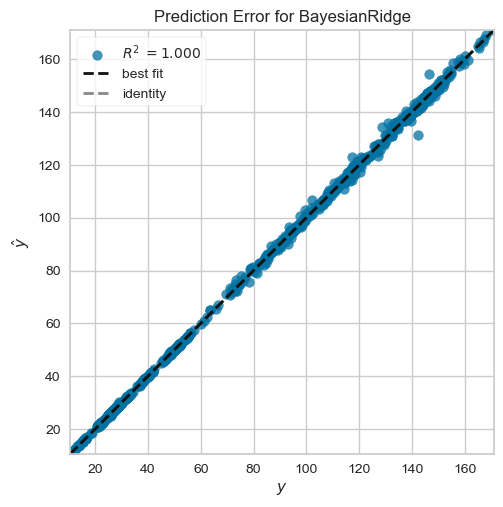

In [35]:
# Error plot
plot_model(tune_br, plot = 'error')

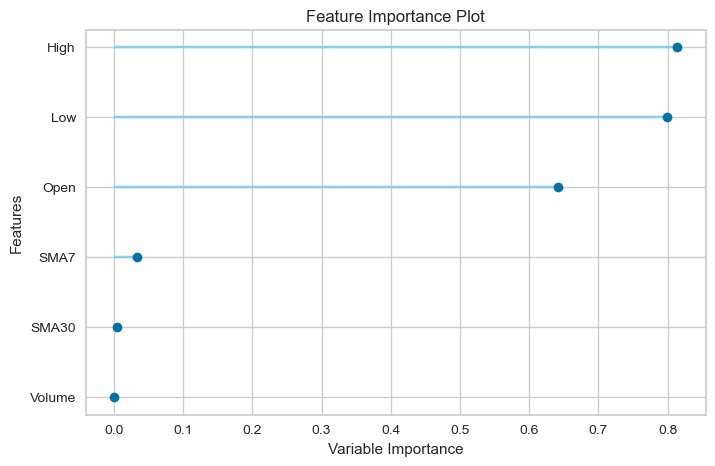

In [36]:
# Importance Feature Plot
plot_model(tune_br, plot = 'feature')

## Finalized Model

In [37]:
# Finalizing model
final_br_model = finalize_model(tune_br)

In [38]:
# Predicting last 2 years
prediction = predict_model(final_br_model,
                          data = blk_predict)
prediction

Open        High         Low   Volume  \
Date                                                                     
2011-09-29 00:00:00-04:00  112.449242  112.486053  109.018272  1147400   
2011-09-30 00:00:00-04:00  109.968002  111.595146  108.679543  1095600   
2011-10-03 00:00:00-04:00  108.090530  109.482063  104.129440  1041900   
2011-10-04 00:00:00-04:00  103.120811  108.650139  100.867851  1300000   
2011-10-05 00:00:00-04:00  108.613281  111.278549  107.133392   869300   
...                               ...         ...         ...      ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010   275200   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005   430900   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988   502600   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998   483900   
2023-08-31 00:00:00-04:00  697.869995  704.440002  693.794983   605366   

                                 SMA7       SMA30       Close  \
Date                                                            
2011-09-29 00:00:00-04:00  109.669998  114.190002  111.661446   
2011-09-30 00:00:00-04:00  109.750000  114.120003  108.974045   
2011-10-03 00:00:00-04:00  109.440002  113.919998  104.379776   
2011-10-04 00:00:00-04:00  109.389999  113.820000  108.377716   
2011-10-05 00:00:00-04:00  109.410004  113.639999  110.799980   
...                               ...         ...         ...   
2023-08-25 00:00:00-04:00  672.799988  709.340027  675.960022   
2023-08-28 00:00:00-04:00  673.510010  707.710022  679.000000   
2023-08-29 00:00:00-04:00  676.479980  706.109985  691.030029   
2023-08-30 00:00:00-04:00  679.940002  704.400024  695.809998   
2023-08-31 00:00:00-04:00  684.900024  702.719971  700.539978   

                           prediction_label  
Date                                         
2011-09-29 00:00:00-04:00        109.625224  
2011-09-30 00:00:00-04:00        110.233095  
2011-10-03 00:00:00-04:00        106.125804  
2011-10-04 00:00:00-04:00        106.085930  
2011-10-05 00:00:00-04:00        109.621153  
...                                     ...  
2023-08-25 00:00:00-04:00        676.831144  
2023-08-28 00:00:00-04:00        677.204747  
2023-08-29 00:00:00-04:00        687.086958  
2023-08-30 00:00:00-04:00        695.815025  
2023-08-31 00:00:00-04:00        699.334531  

[3000 rows x 8 columns]

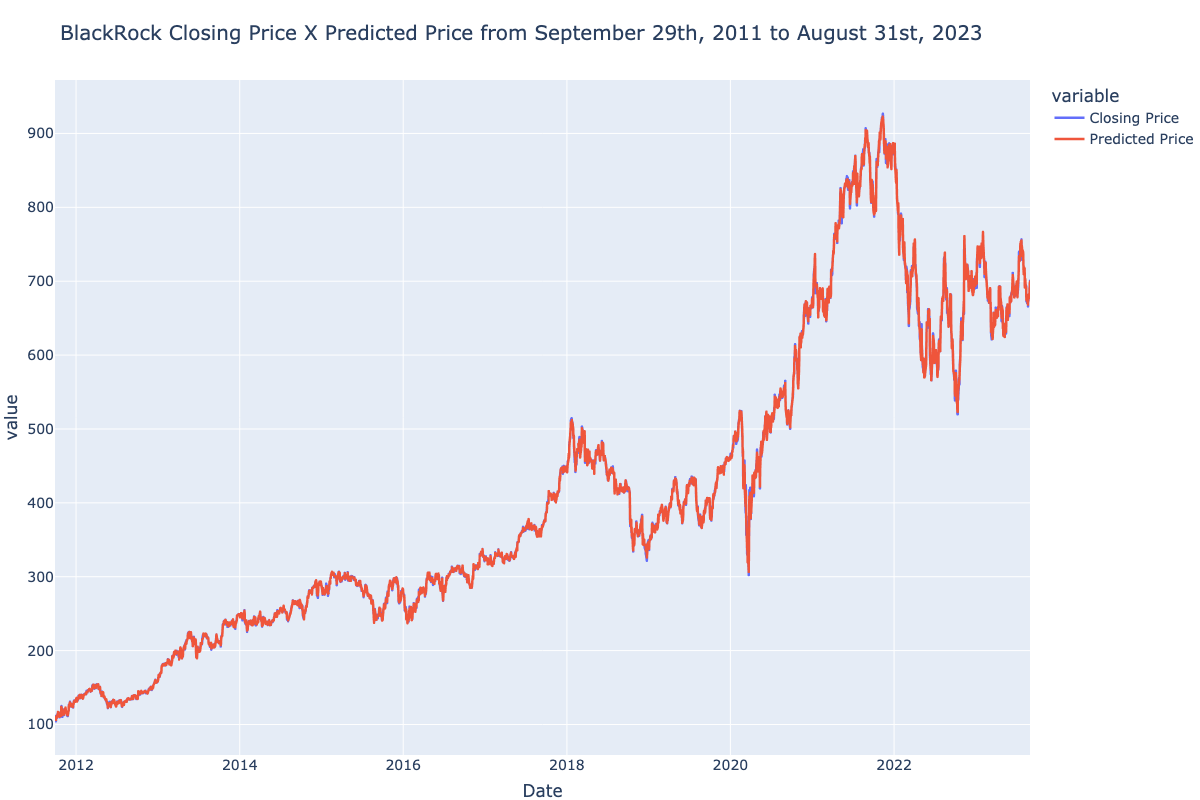

In [39]:
# Round the necessary columns first
prediction['Close'] = prediction['Close'].round(2)
prediction['prediction_label'] = prediction['prediction_label'].round(2)

fig = px.line(prediction, 
              x=prediction.index, 
              y=['Close', 'prediction_label'], 
              title='BLK close price x predicted price from September 29th, 2011 to August 31st, 2023')

newnames = {'Close':'Closing Price', 'prediction_label': 'Predicted Price'}  # Updated the mapping
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title='BlackRock Closing Price X Predicted Price from September 29th, 2011 to August 31st, 2023',
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(size=14)
)
fig.show("png")


In [23]:
setup(data = blk, target = 'SMA7',session_id=123)

In [24]:
ridge = create_model('ridge',fold = 10)

In [25]:
br = create_model('br',fold=10)

In [26]:
lar = create_model('lar',fold=10)

In [27]:
# Tuning ridge
ridge_params = {'alpha' : [0.02,0.024,0.025,0.025,0.026,0.03]}
tune_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE',custom_grid = ridge_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
# Tuning Bayesian Ridge
tune_br = tune_model(br,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


In [29]:
# Tuning Least Angle Regression 
tune_lar = tune_model(lar,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 22 candidates, totalling 220 fits


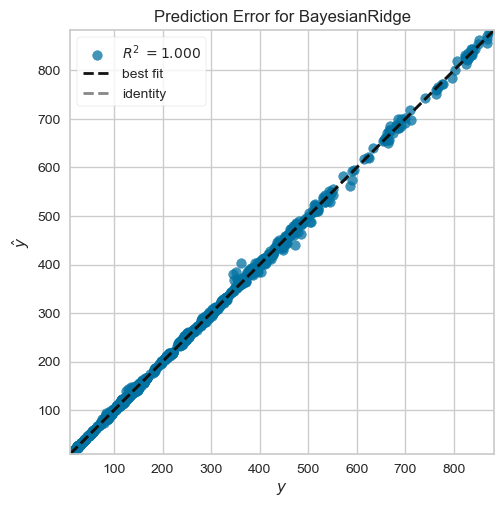

In [31]:
# Error plot
plot_model(tune_br, plot = 'error')

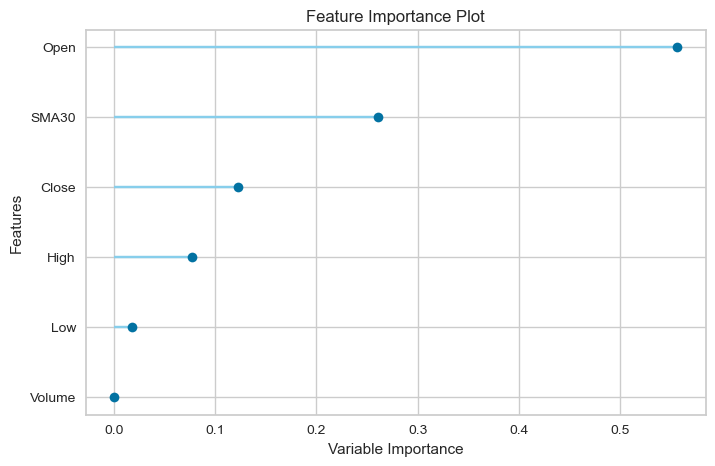

In [32]:
# Importance Feature Plot
plot_model(tune_br, plot = 'feature')

In [33]:
# Finalizing model
final_br_model = finalize_model(tune_br)

In [34]:
# Predicting last 2 years
prediction = predict_model(final_br_model,
                          data = blk_predict)
prediction

Open        High         Low       Close  \
Date                                                                        
2021-08-27 00:00:00-04:00  891.600098  907.109070  891.600098  906.928650   
2021-08-30 00:00:00-04:00  911.078979  911.629883  899.938782  900.413635   
2021-08-31 00:00:00-04:00  902.370056  905.314209  892.787354  895.864441   
2021-09-01 00:00:00-04:00  897.488464  899.853271  889.900208  896.367798   
2021-09-02 00:00:00-04:00  901.638733  906.843201  898.533081  902.873352   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.414978  693.794983  700.539978   

                           Volume       SMA30        SMA7  prediction_label  
Date                                                                         
2021-08-27 00:00:00-04:00  454600  851.770020  883.020020        884.401080  
2021-08-30 00:00:00-04:00  284000  855.030029  889.030029        895.787496  
2021-08-31 00:00:00-04:00  595000  857.070007  892.570007        890.466855  
2021-09-01 00:00:00-04:00  324200  859.000000  894.739990        888.366330  
2021-09-02 00:00:00-04:00  349400  861.650024  897.650024        892.292826  
...                           ...         ...         ...               ...  
2023-08-25 00:00:00-04:00  275200  709.340027  672.799988        685.210459  
2023-08-28 00:00:00-04:00  430900  707.710022  673.510010        688.529334  
2023-08-29 00:00:00-04:00  502600  706.109985  676.479980        688.310944  
2023-08-30 00:00:00-04:00  483900  704.400024  679.940002        696.230175  
2023-08-31 00:00:00-04:00  426809  702.719971  684.900024        700.182491  

[506 rows x 8 columns]

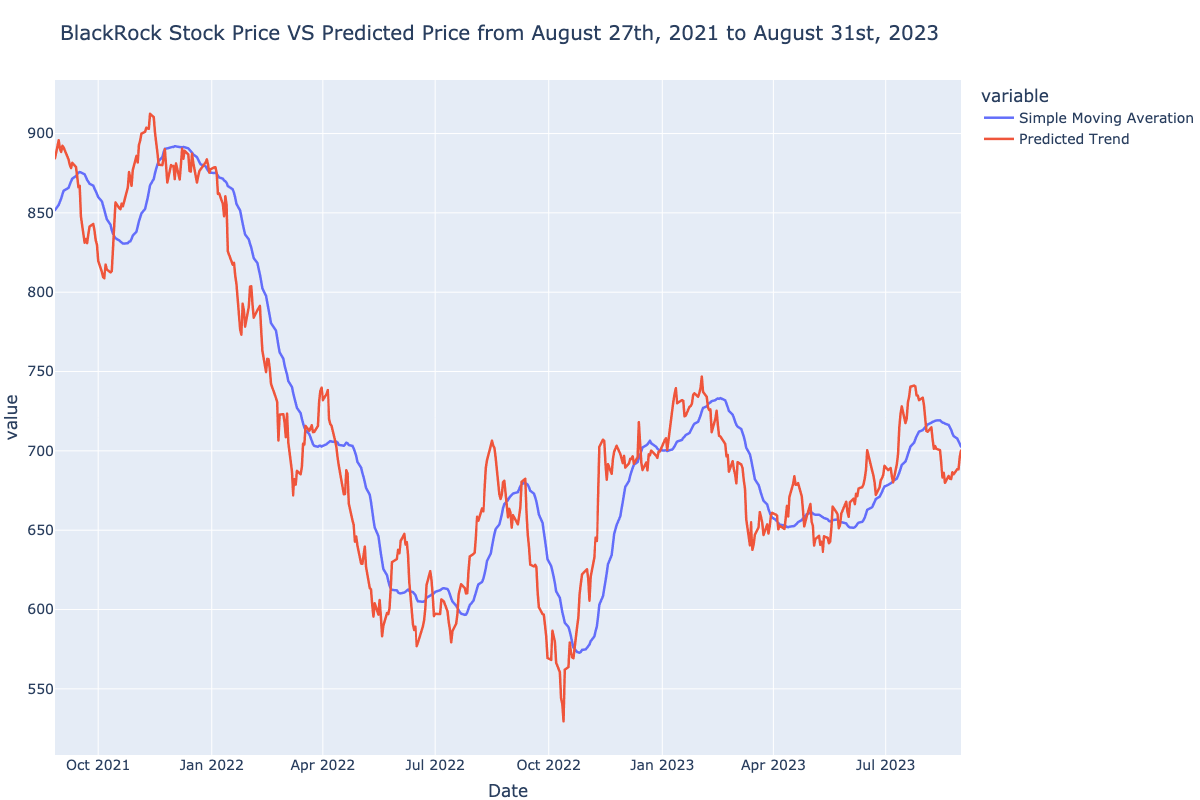

In [35]:
# Round the necessary columns first
prediction['SMA30'] = prediction['SMA30'].round(2)
prediction['prediction_label'] = prediction['prediction_label'].round(2)

fig = px.line(prediction, 
              x=prediction.index, 
              y=['SMA30', 'prediction_label'], 
              title='BLK stock price vs predicted price from August 27th, 2021 to August 31st, 2023')

newnames = {'SMA30':'Simple Moving Averation', 'prediction_label': 'Predicted Trend'}  # Updated the mapping
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title='BlackRock Stock Price VS Predicted Price from August 27th, 2021 to August 31st, 2023',
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(size=14)
)
fig.show("png")

## Conclusion

Now this model is much better, I found that the Pycaret makes it the easy way to do all the modeling for predictions